In [58]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display as librosadisplay

import logging
import math
import statistics
import sys

from IPython.display import Audio, Javascript
from scipy.io import wavfile

from base64 import b64decode

import music21
from pydub import AudioSegment

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

print("tensorflow: %s" % tf.__version__)
#print("librosa: %s" % librosa.__version__)


uploaded_file_name = 'creep_by_radiohead.wav'

EXPECTED_SAMPLE_RATE = 16000

def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
  audio = AudioSegment.from_file(user_file)
  audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
  audio.export(output_file, format="wav")
  return output_file

converted_audio_file = convert_audio_for_model(uploaded_file_name)


tensorflow: 2.15.0


In [59]:
# Loading audio samples from the wav file:
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

# Show some basic information about the audio.
duration = len(audio_samples)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')

# Let's listen to the wav file.
Audio(audio_samples, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 9.45s
Size of the input: 151190


In [60]:
MAX_ABS_INT16 = 32768.0
audio_samples = audio_samples / float(MAX_ABS_INT16)

# Loading the SPICE model is easy:
#model = hub.load("https://tfhub.dev/google/spice/2")
model = hub.load("https://www.kaggle.com/models/google/spice/frameworks/TensorFlow1/variations/spice/versions/2")




296
296


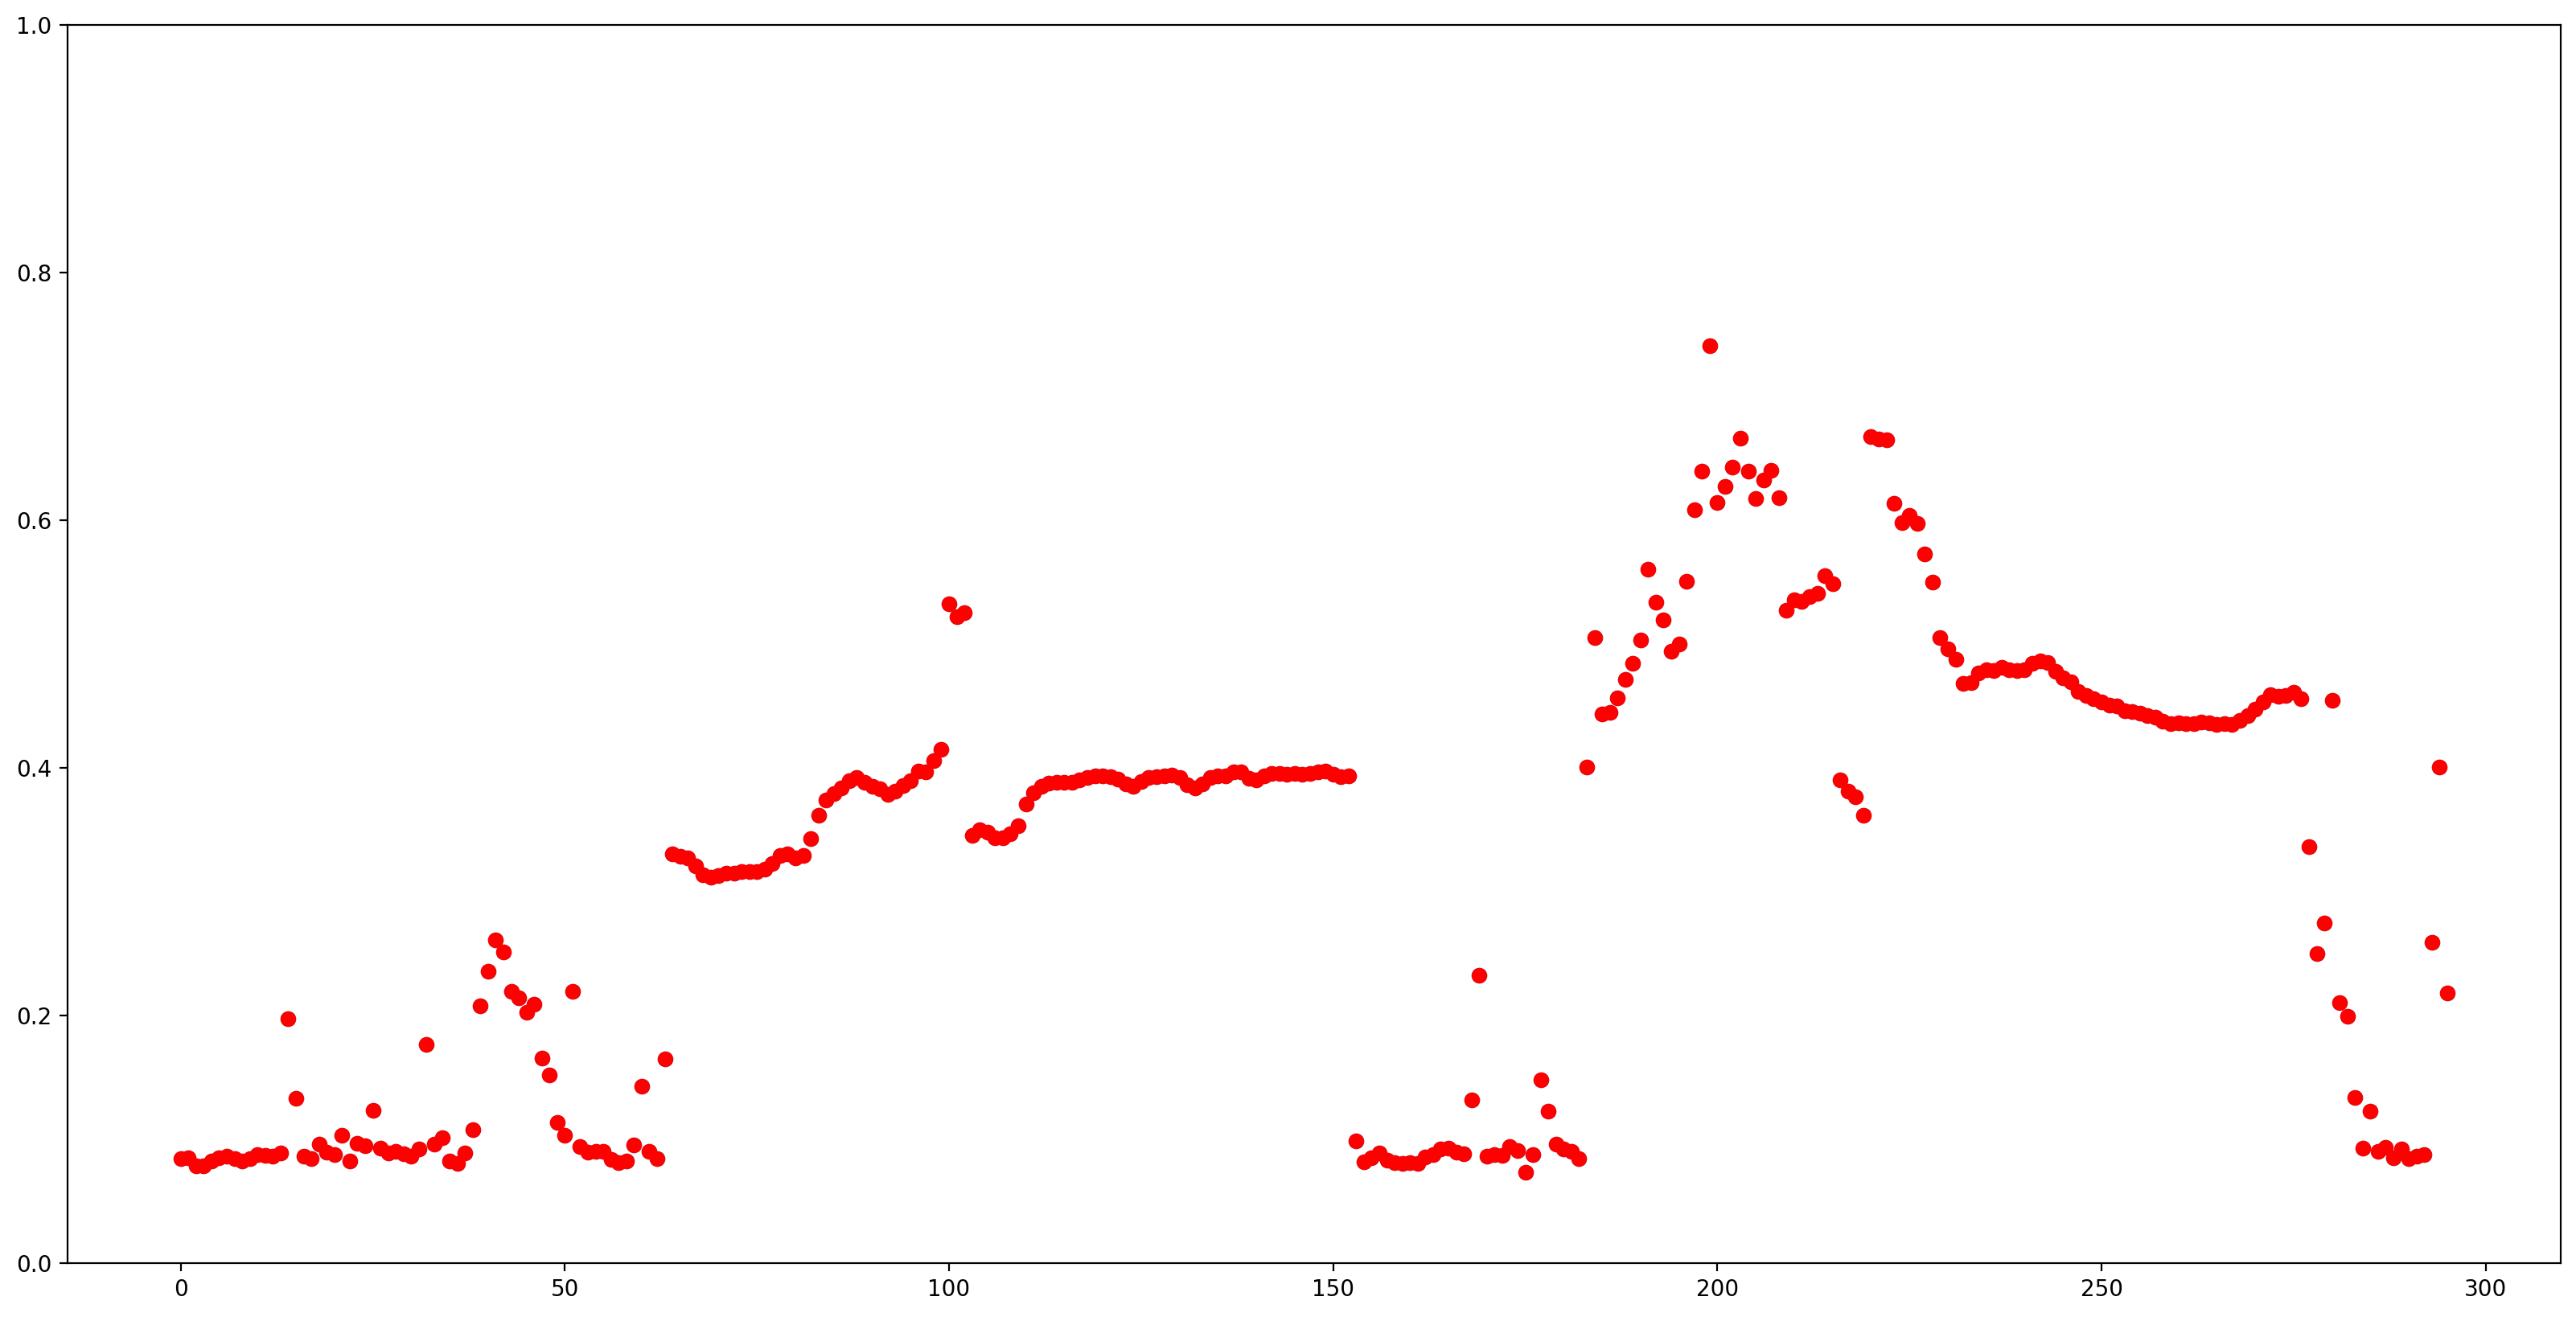

In [61]:
# We now feed the audio to the SPICE tf.hub model to obtain pitch and uncertainty outputs as tensors.
model_output = model.signatures["serving_default"](tf.constant(audio_samples, tf.float32))


pitch_outputs = model_output["pitch"]
uncertainty_outputs = model_output["uncertainty"]

# 'Uncertainty' basically means the inverse of confidence.
confidence_outputs = 1.0 - uncertainty_outputs

confidence_outputs = list(confidence_outputs)
pitch_outputs = [ float(x) for x in pitch_outputs]

print(len(confidence_outputs))
print(len(pitch_outputs))

indices = range(len (pitch_outputs))
# No longer thresholding un-confident pitches out 
confident_pitch_outputs = [ (i,p)  
  for i, p, c in zip(indices, pitch_outputs, confidence_outputs)]
confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)


# indices = range(len (pitch_outputs))
# confident_pitch_outputs = [ (i,p)  
#   for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= 0.9  ]
# confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_ylim([0, 1])
plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, )
plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, c="r")

plt.show()

In [62]:
def output2hz(pitch_output):
  # Constants taken from https://tfhub.dev/google/spice/2
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0;
  BINS_PER_OCTAVE = 12.0;
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)
    
confident_pitch_values_hz = [ output2hz(p) for p in confident_pitch_outputs_y ]

In [78]:

time_interval_per_pitch = duration / len(confident_pitch_values_hz)
#print(time_interval_per_pitch)

# Generate timestamps for each pitch value
timestamps = np.arange(len(pitch_outputs)) * time_interval_per_pitch

# Pair each pitch with its corresponding timestamp
pitch_time_pairs = list(zip(confident_pitch_values_hz, timestamps))

# PITCH TIME PAIRS NOW STORES THE CONFIDENCE ALONG WITH THE PITCH

# Calculate the gradient
gradient = []
for i in range(len(pitch_time_pairs) - 1):
    pitch1, time1 = pitch_time_pairs[i]
    pitch2, time2 = pitch_time_pairs[i + 1]
    slope = (pitch2 - pitch1) / (time2 - time1)
    gradient.append(slope)

pitch_gradient_time = [(gradient[i], pitch_time_pairs[i][0], pitch_time_pairs[i][1]) for i in range(len(gradient))]

def calc_mad(list):
    assert(len(list) != 0)
    data = np.array(list)
    mean = np.mean(data)
    mad = np.mean(np.abs(data - mean))
    return mad

window = 1
shift = 0.5
curr = 0
assert(shift < window)
list_of_windows = []
list_of_window_start_times = []
while curr < duration:
    window_vals = []
    stop_timestamp = curr + window
    for i in range(len(pitch_gradient_time)):
        if pitch_gradient_time[i][2] <= stop_timestamp:
            window_vals.append([pitch_gradient_time[i][0], pitch_gradient_time[i][1]])
        else:
            break
    list_of_windows.append(window_vals)
    list_of_window_start_times.append(curr)
    curr += shift

list_of_window_mad_gradient = []
list_of_window_mad_pitch = []
for i in range(len(list_of_windows)):
    window = list_of_windows[i]
    gradients = []
    pitches = []
    for j in range(len(window)):
        gradients.append(window[j][0])
        pitches.append(window[j][1])
    list_of_window_mad_gradient.append(calc_mad(gradients))
    list_of_window_mad_pitch.append(calc_mad(pitches))
print(len(list_of_window_mad_pitch))
print(len(list_of_window_mad_gradient))
print(len(list_of_window_start_times))


19
19
19


In [ ]:
#print(confident_pitch_values_hz)

time_interval_per_pitch = duration / len(confident_pitch_values_hz)
#print(time_interval_per_pitch)

# Generate timestamps for each pitch value
timestamps = np.arange(len(pitch_outputs)) * time_interval_per_pitch

# Pair each pitch with its corresponding timestamp
pitch_time_pairs = list(zip(confident_pitch_values_hz, timestamps))
#print(pitch_time_pairs)

threshold_for_marker = 2
timestamps_exceeding_threshold = []

# Get a list of all the timestamps where pitches exceed the threshold
for i in range(len(pitch_time_pairs) - 1):
    current_pitch, _ = pitch_time_pairs[i]
    next_pitch, next_timestamp = pitch_time_pairs[i + 1]

    if abs(next_pitch - current_pitch) > threshold_for_marker:
        timestamps_exceeding_threshold.append(next_timestamp)

print("There are in total ", len(pitch_time_pairs), " pitch-time pairs.")
print("There are in total ", len(timestamps_exceeding_threshold), " pitch-time pairs that exeed the threshold of ", threshold_for_marker, "units.")
print(timestamps_exceeding_threshold)

There are in total  296  pitch-time pairs.
There are in total  157  pitch-time pairs that exeed the threshold of  2 units.
[0.4469298986486486, 0.4788534628378378, 0.510777027027027, 0.5746241554054053, 0.6703948479729729, 0.7023184121621621, 0.7342419763513512, 0.7980891047297297, 0.8300126689189189, 1.021554054054054, 1.0534776182432433, 1.1173247466216216, 1.213095439189189, 1.2450190033783783, 1.2769425675675674, 1.3088661317567567, 1.3407896959459458, 1.372713260135135, 1.4365603885135134, 1.4684839527027025, 1.5004075168918918, 1.532331081081081, 1.5642546452702701, 1.5961782094594594, 1.6281017736486485, 1.6600253378378378, 1.883490287162162, 1.9154138513513512, 1.9473374155405403, 2.011184543918919, 2.043108108108108, 2.1388788006756756, 2.1708023648648647, 2.458114442567567, 2.4900380067567567, 2.6177322635135134, 2.6496558277027025, 2.6815793918918915, 2.713502956081081, 2.74542652027027, 2.777350084459459, 2.8411972128378378, 2.936967905405405, 3.0008150337837836, 3.03273859